<a href="https://colab.research.google.com/github/SamueleSoraggi/scRNA-tutorial/blob/master/Example_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**FIRST BREAKOUTROOM SESSION STARTS HERE**

## UMI-based single cell data

The dataset we are using in this tutorial is based on a microdroplet-based method from 10X chromium. From today's lecture we remember that the single cell sequencing protocol works as follow:

- each cell is isolated together with a barcode bead in a gel/oil droplet
- each transcript in the cell is captured via the bead and assigned a cell barcode and a transcript unique molecular identifier (UMI)
- 3' reverse transcription of mRNA into cDNA is then performed in preparation to the PCR amplification
- the cDNA is amplified through PCR cycles
- the resulting reads are ready to go through a dedicated pipeline for transcriptome alignment.

Let's look at a specific read and its UMI and cell barcode. The data is organized in paired-end reads (written on `fastq` files), where the first `fastq` file contains reads in the following format 

```
@SRR8363305.1 1 length=26
NTGAAGTGTTAAGACAAGCGTGAACT
+SRR8363305.1 1 length=26
#AAFFJJJJJJJJJJJJJJJJFJJJJ
```

Here, the first 16 characters `NTGAAGTGTTAAGACA` represent the cell barcode, while the last 10 characters `AGCGTGAACT` are the transcript UMI tag. The last line represents the quality scores of the 26 characters of barcode+UMI.

The associated second `fastq` file contains reads of 98nt as the following
```
@SRR8363305.1 1 length=98
NCTAAAGATCACACTAAGGCAACTCATGGAGGGGTCTTCAAAGACCTTGCAAGAAGTACTAACTATGGAGTATCGGCTAAGTCAANCNTGTATGAGAT
+SRR8363305.1 1 length=98
#A<77AFJJFAAAJJJ7-7-<7FJ-7----<77--7FAAA--<JFFF-7--7<<-F77---FF---7-7A-777777A-<-7---#-#A-7-7--7--
```
The 98nt-long string of characters in the second line is a partial sequence of the cDNA transcript. Specifically, the 10X chromium protocol used for sequencing the data is biased towards the 3' end, because the sequencing happens from the 3' to the 5' end of the transcripts. The last line contains the corresponding quality scores.

Once the data is sequenced, it is possible to align the reads to the transcriptome. This is done with splice-aware aligners that are sensitive to the presence of spliced transcripts. We will skip the alignment step because it is quite trivial (it requires a pipeline implemented by 10X, where one has to prepare only the data folders), and because it would require too much memory for the resources we have available on Google Colab. Instead, we start from the transcript count matrix that results as the output from the transcriptome alignment.

## Install and import the packages necessary to run this python notebook
We will use *scanpy* as the main analysis tool for the analysis. Scanpy has a comprehensive [manual webpage](https://scanpy.readthedocs.io/en/stable/) that includes many different tutorial you can use for further practicing, and is used for the discussion paper and the tutorial paper of this course. 
An alternative and well-established tool for R users is [Seurat](https://satijalab.org/seurat/). However, scanpy is mainatined and updated by a wider community with many of the latest developed tools.

ignore all the messages you see when installing the various packages

In [1]:
!pip install scanpy
!pip install scvelo
!pip install leiden
!pip install seaborn
!pip install bbknn
!pip install leidenalg
!pip install palantir
!pip install annoy==1.13.0
!pip install gseapy
!pip install diffxpy

     |████████████████████████████████| 7.2MB 2.4MB/s 
     |████████████████████████████████| 122kB 43.6MB/s 
     |████████████████████████████████| 51kB 5.4MB/s 
     |████████████████████████████████| 225kB 2.7MB/s 
     |████████████████████████████████| 51kB 6.1MB/s 
     |████████████████████████████████| 51kB 5.7MB/s 
  Created wheel for loompy: filename=loompy-3.0.6-cp36-none-any.whl size=47895 sha256=c55fec7013ca97a992540916951d7ca28d607f152d57701256ff80d62f0570e0
  Stored in directory: /root/.cache/pip/wheels/f9/a4/90/5a98ad83419732b0fba533b81a2a52ba3dbe230a936ca4cdc9
  Created wheel for numpy-groupies: filename=numpy_groupies-0+unknown-cp36-none-any.whl size=28042 sha256=c60a50d8b6e13720c79fe38b73ab13e239f0a7edf54482dc36d422c525a06555
  Stored in directory: /root/.cache/pip/wheels/30/ac/83/64d5f9293aeaec63f9539142fc629a41af064cae1b3d8d94aa
Successfully built loompy numpy-groupies
     |████████████████████████████████| 163kB 3.9MB/s 
     |████████████████████████████████| 

In [2]:
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import gseapy as gp
import diffxpy.api as de

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Creating directory /root/.config/bioservices 


**Download datasets**

In [3]:
!wget https://www.dropbox.com/s/r5hyuqwhcujko0t/testisGuo.h5ad?dl=0 -O testisGuo.h5ad #single cell data

--2020-06-26 11:20:01--  https://www.dropbox.com/s/r5hyuqwhcujko0t/testisGuo.h5ad?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.1, 2620:100:6032:1::a27d:5201
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/r5hyuqwhcujko0t/testisGuo.h5ad [following]
--2020-06-26 11:20:01--  https://www.dropbox.com/s/raw/r5hyuqwhcujko0t/testisGuo.h5ad
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc67739ac15ee372b25530468e9e.dl.dropboxusercontent.com/cd/0/inline/A6Z8keSP9905q-Qq8ZEj90WOrdgrdlMDB6a8o9bV3A9gxCnU-mWK0HI313AqZJLcyJTxEyNqW4o03-GGkx18uc8NidevtpSETGVChdyM1Gy0aEL5G2JVd5yLKuHlm0i6Sig/file# [following]
--2020-06-26 11:20:02--  https://uc67739ac15ee372b25530468e9e.dl.dropboxusercontent.com/cd/0/inline/A6Z8keSP9905q-Qq8ZEj90WOrdgrdlMDB6a8o9bV3A9gxCnU-mWK0HI313AqZJLcyJTxEyNqW4o03-GGkx18uc8NidevtpSETGVC

##Loading and understanding the dataset

There are many different possible formats. Each format has a dedicated reading command in scanpy, for example `read_h5ad`, `read_10X` ....

In [4]:
adata = sc.read_h5ad('testisGuo.h5ad')

The data is opened and an `Annotated data` object called `adata` is created. This object contains:


*   The data matrix `adata.X` of size $N\_cells \times N\_genes$
*   Vectors of cells-related variables in the dataframe `adata.obs`
* Vectors of genes-related variables in the dataframe `adata.var`
* Matrices of size $N\_cells \times N\_genes$ in `adata.layers`
* Matrices where each line is cell-related in `adata.obsm`
* Matrices where each line is gene-related in `adata.varm`
* Anything else that must be saved in `adata.uns`

The cells are called observations (obs) and the genes variables (var).

![alt text](https://falexwolf.de/img/scanpy/anndata.svg)


In [5]:
adata

AnnData object with n_obs × n_vars = 2500 × 7500
    obs: 'batch'

We calculate quality measures to fill the object `adata` with some observations and variables

In [6]:
sc.preprocessing.calculate_qc_metrics(adata, inplace=True)

We can see that now `adata` contains many observations and variables. Those can be used for analysis purpose, as well as they might be needed by some scanpy tools

In [7]:
adata

AnnData object with n_obs × n_vars = 2500 × 7500
    obs: 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

`adata.obs` is a dataframe, i.e. a table with indexes on the rows (cell barcodes) and column names (the observation types). One can select a specific observation type by indexing it in the table

In [8]:
adata.obs

,batch,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes
CTGCTGTAGACCACGA-1-1,SAM_2,484,6.184149,3102.0,8.040125,83.558994,87.201805,90.844616,100.000000
ATTACTCCACGCCAGT-2-1,SAM_2,395,5.981414,2828.0,7.947679,85.961810,89.497878,93.104668,100.000000
CGTCTACCAAGACACG-2-2,SAM_3,1166,7.062192,2862.0,7.959625,39.937107,48.497554,59.364081,76.729560
GCACATATCACCCTCA-2-1,SAM_2,751,6.622736,4427.0,8.395703,78.744070,82.471199,87.192230,94.330246
AGAGCGAAGTCGTACT-1-0,SAM_1,416,6.033086,1253.0,7.134094,63.687151,72.545890,82.761373,100.000000
...,...,...,...,...,...,...,...,...,...
TCGTACCAGCTGGAAC-2-2,SAM_3,658,6.490724,1919.0,7.560081,54.403335,64.095883,75.091193,91.766545
CCGTTCAGTTCGGCAC-1-2,SAM_3,358,5.883322,3467.0,8.151333,89.991347,92.558408,95.442746,100.000000
GGGCACTTCGTGTAGT-2-2,SAM_3,1697,7.437206,5879.0,8.679312,27.759823,39.445484,53.189318,73.532914
AACGTTGGTGATAAGT-1-2,SAM_3,1244,7.126891,2915.0,7.977968,26.998285,37.152659,50.771870,73.996569


In [9]:
adata.obs['batch']

CTGCTGTAGACCACGA-1-1    SAM_2
ATTACTCCACGCCAGT-2-1    SAM_2
CGTCTACCAAGACACG-2-2    SAM_3
GCACATATCACCCTCA-2-1    SAM_2
AGAGCGAAGTCGTACT-1-0    SAM_1
                        ...  
TCGTACCAGCTGGAAC-2-2    SAM_3
CCGTTCAGTTCGGCAC-1-2    SAM_3
GGGCACTTCGTGTAGT-2-2    SAM_3
AACGTTGGTGATAAGT-1-2    SAM_3
ACATCAGGTTACGTCA-2-0    SAM_1
Name: batch, Length: 2500, dtype: category
Categories (3, object): [SAM_1, SAM_2, SAM_3]

`adata.var` works similarly, but now each row is referred to the genes

In [10]:
adata.var

,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
AP006222.2,598,0.380000,0.322084,76.08,950.0,6.857514
RP11-206L10.9,669,0.701600,0.531569,73.24,1754.0,7.470224
FAM41C,293,0.188000,0.172271,88.28,470.0,6.154858
SAMD11,193,0.116800,0.110467,92.28,292.0,5.680172
HES4,193,0.122400,0.115469,92.28,306.0,5.726848
...,...,...,...,...,...,...
MT-ND3,2414,82.879997,4.429387,3.44,207200.0,12.241445
AC136616.1,369,0.242800,0.217367,85.24,607.0,6.410175
AC007325.1,17,0.010800,0.010742,99.32,27.0,3.332205
AC023491.2,67,0.157200,0.146003,97.32,393.0,5.976351


In [11]:
adata.var['n_cells_by_counts']

AP006222.2        598
RP11-206L10.9     669
FAM41C            293
SAMD11            193
HES4              193
                 ... 
MT-ND3           2414
AC136616.1        369
AC007325.1         17
AC023491.2         67
AC240274.1        560
Name: n_cells_by_counts, Length: 7500, dtype: int64

##Preprocessing

We preprocess the dataset according to different quality measures and by filtering doublets

Using the prefix `MT-` in the gene names we calculate the percentage of mithocondrial genes in each cell, and store this value as an observation in `adata`. Cells with high MT percentage are often broken cells that spilled out mithocondrial content (in this case they will often have low gene and transcript counts), or cells captured together with residuals of broken cells (more unlikely if a good job in the sequencing lab has been done)

In [12]:
MT = ['MT-' in i for i in adata.var_names] #a vector with True and False to find MT genes

In [13]:
perc_mito = np.sum( adata[:,MT].X, 1 ).A1 / np.sum( adata.X, 1 ).A1
adata.obs['perc_mito'] = perc_mito.copy()

One can identify cells to be filtered out by looking at the relation between number of transcripts per cell (horizontal axis) and number of genes per cell (vertical axis), coloured by percentage of MT genes. Here, a possibility could be to exclude cells with >20000 transcripts, >2500 genes, <500 genes or >20% MT genes. Note that many cells with high MT percentage have a relatively low number of transcripts.

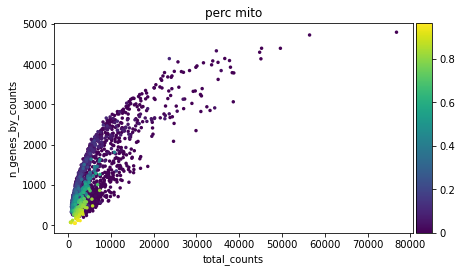

In [14]:
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', color='perc_mito')

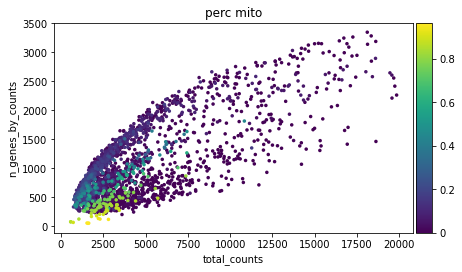

In [15]:
sc.pl.scatter(adata[adata.obs['total_counts']<20000], x='total_counts', y='n_genes_by_counts', color='perc_mito')

Another useful visualization is the distribution of each quality feature of the data. We set red lines at the thresholds decided above

Text(0.5, 1.0, 'Distribution of MT genes percentage per cell')

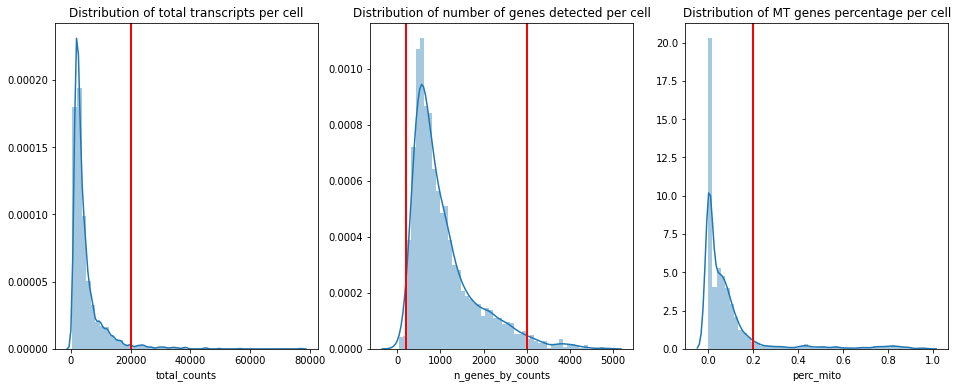

In [16]:
plt.rcParams['figure.figsize'] = (16,6)
f, ax = plt.subplots(1,3)

sns.distplot(adata.obs['total_counts'], ax=ax[0], bins=50)
ax[0].axvline(20000, color='red', linewidth=2)
ax[0].set_title('Distribution of total transcripts per cell')

sns.distplot(adata.obs['n_genes_by_counts'], ax=ax[1], bins=50)
ax[1].axvline(200, color='red', linewidth=2)
ax[1].axvline(3000, color='red', linewidth=2)
ax[1].set_title('Distribution of number of genes detected per cell')

sns.distplot(adata.obs['perc_mito'], ax=ax[2], bins=50)
ax[2].axvline(0.2, color='red', linewidth=2)
ax[2].set_title('Distribution of MT genes percentage per cell')

Here we apply the various filters

In [17]:
sc.preprocessing.filter_cells(adata, max_genes=3000)

In [18]:
sc.preprocessing.filter_cells(adata, min_genes=200)

In [19]:
sc.preprocessing.filter_cells(adata, max_counts=20000)

In [20]:
adata = adata[adata.obs['perc_mito']<0.2].copy()

Look again at the distributions of quality measures

Text(0.5, 1.0, 'Distribution of MT genes percentage per cell')

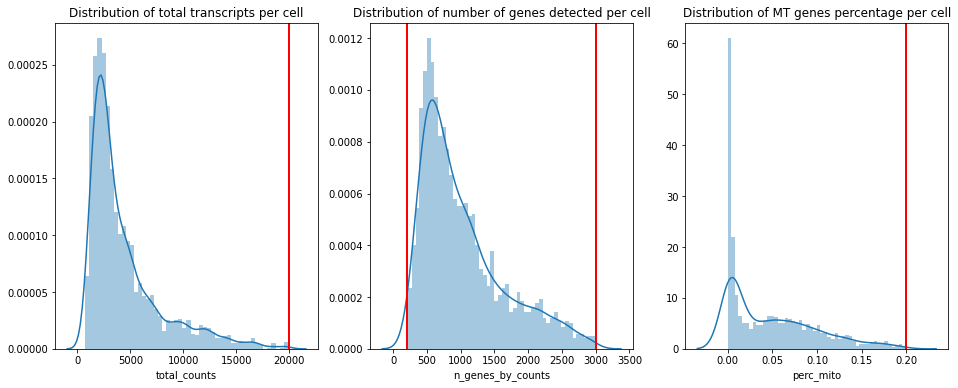

In [21]:
plt.rcParams['figure.figsize'] = (16,6)
f, ax = plt.subplots(1,3)

sns.distplot(adata.obs['total_counts'], ax=ax[0], bins=50)
ax[0].axvline(20000, color='red', linewidth=2)
ax[0].set_title('Distribution of total transcripts per cell')

sns.distplot(adata.obs['n_genes_by_counts'], ax=ax[1], bins=50)
ax[1].axvline(200, color='red', linewidth=2)
ax[1].axvline(3000, color='red', linewidth=2)
ax[1].set_title('Distribution of number of genes detected per cell')

sns.distplot(adata.obs['perc_mito'], ax=ax[2], bins=50)
ax[2].axvline(0.2, color='red', linewidth=2)
ax[2].set_title('Distribution of MT genes percentage per cell')

It is good practice to remove those genes found in too few cells (for example in 5 or less cells)

In [22]:
sc.preprocessing.filter_genes(adata, min_cells=5)

In [23]:
print('There are now', adata.shape[0], 'cells and', adata.shape[1],'genes')

There are now 2154 cells and 7394 genes


##Normalize the data

Biologically similar cells are not necessarily **directly comparable** in a dataset because of different technical biases, amongst many the different percentage of captured transcripts (capture efficiency), the presence of technical replicates, the presence of noisy transcripts. The capture efficiency can be influenced by many factors, i.e. the different transcript tags leading to different capture efficiency, the type of protocol in used in the laboratory, the amount of PCR performed on different transcripts. Biological biases might as well alter the transcript proportion in a cell, for example in case of different points in the cell cycles altering the expression of specific genes.

To avoid these differences, a **normalization** approach is needed. Normalization is one of the main topics of scRNAseq data preprocessing, and many advanced techniques taking into account the statistical distribution of counts and the presence of technical/biological features of interest.

The most standard approach is the **TMP (Transcript Per Million) normalization**. Here, the transcripts is each cell are rescaled with the same factor, so that the transcripts in each cell sum to the same value. After TPM rescaling, the data is usually logarithmized, so that a transcript $x$ becomes $log(x+1)$. Logarithmization is known to help reducing the technical bias induced by the amount of transcripts in each cell. Finally, the data is standardized with mean 0 and variance 1. This is necessary since the PCA assumes implicitly that datapoints are normally distributed.

As a rule of thumb, TPM is not any longer consider a very good normalization technique. Instead, it is suggested to use more advanced methods for considering technical and biological covariates as part of a statistical model for the transcripts. One of the current state-of-the-art method is *scTransform*. This is implemented in R, but *scanpy* has an interface to it (requires the installation of *rpy2*, a package to use R in python notebooks, and of the R package *scTransform*).

During the various steps of normalization, logarithmization, standardization we save the data matrices in `adata.layers` for further use - this is useful if one needs a specific matrix for calculations.

In [24]:
adata.layers['raw_counts'] = adata.X.copy()

sc.pp.normalize_per_cell(adata)
adata.layers['tpm_counts'] = adata.X.copy()

sc.pp.log1p(adata)
adata.layers['log_counts'] = adata.X.copy()

sc.pp.scale(adata)
adata.layers['gauss_counts'] = adata.X.copy()

Normalization has two effects. The first is diminishing the effect of technical biases on the data. Below, on the left, the correlation of the first PCA component with the transcripts per cell. We can see a high correlation, meaning that this technical feature dominates the data and covers biological signals. On the left the same plot for normalized data, where this effect is mitigated.

Text(0.5, 1.0, 'PC1-vs-transcript of normalized transcripts')

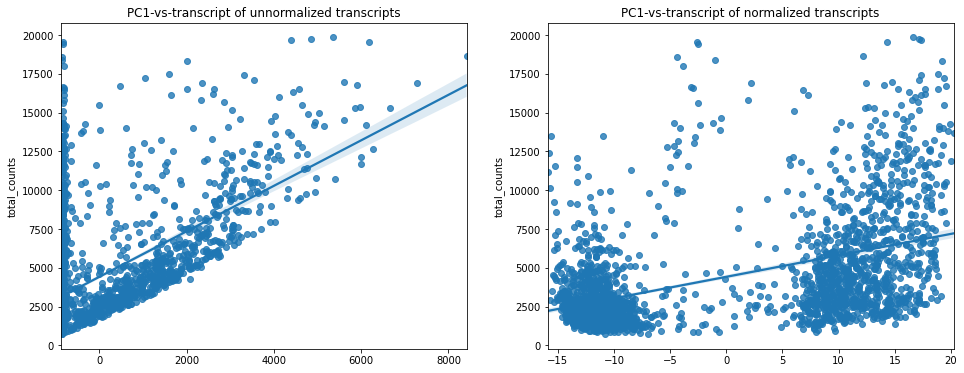

In [29]:
plt.rcParams['figure.figsize'] = (16,6)
f, ax = plt.subplots(1,2)
#pca on raw counts
adata.X = adata.layers['raw_counts']
sc.preprocessing.pca(adata, random_state=12345)
sns.regplot(adata.obsm['X_pca'][:,0], adata.obs['total_counts'] , ax=ax[0])
ax[0].set_title('PC1-vs-transcript of unnormalized transcripts')
#pca on scaled-logaritmized counts
adata.X = adata.layers['log_counts']
sc.preprocessing.pca(adata, random_state=12345)
sns.regplot(adata.obsm['X_pca'][:,0], adata.obs['total_counts'], ax=ax[1])
ax[1].set_title('PC1-vs-transcript of normalized transcripts')

The second effect is altering the expression of genes, each of which is standardized over all cells to have mean 0 and standard deviation 1. Look below at how different is the expression of the gene PRM1. On the left, on unnormalized data, the expression distribution is dominated by the 0 values. On the right, there are two modes of over expression and underexpression compared to the mean (now 0).

Text(0.5, 1.0, 'Distribution of PRM1 normalized transcripts')

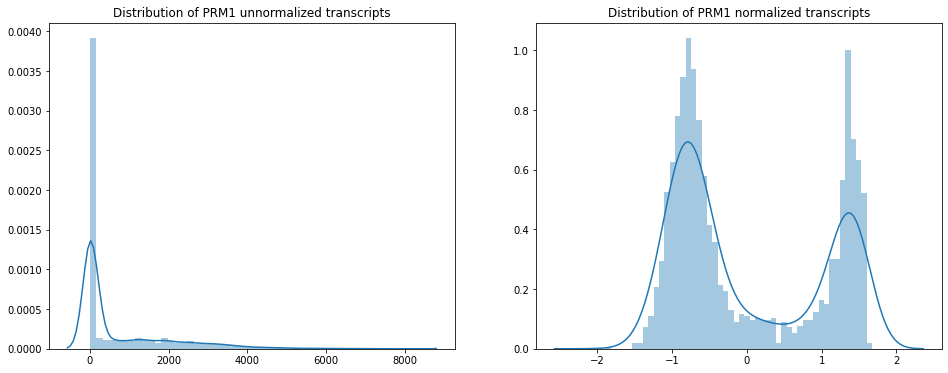

In [26]:
plt.rcParams['figure.figsize'] = (16,6)
f, ax = plt.subplots(1,2)

sns.distplot(adata[:,'PRM1'].layers['raw_counts'].todense(), ax=ax[0], bins=50)
ax[0].set_title('Distribution of PRM1 unnormalized transcripts')

sns.distplot(adata[:,'PRM1'].X, ax=ax[1], bins=50)
ax[1].set_title('Distribution of PRM1 normalized transcripts')

##Dimensionality reduction

With the term **dimensionality reduction**, we intend the projection of each data point (cell) $x=[x_1, x_2, \dots, x_{N_{cell}}]$ into a data point $y$ in  $D$ dimensions, so that $y=[y_1, y_2, \dots, y_D]$, where $D << N_{cell}$.

![](https://blackboard.au.dk/bbcswebdav/pid-2693257-dt-content-rid-8808321_1/xid-8808321_1)

Dimensionality reduction is meaningful for single cell data analysis, since we know that the genes are expressed in modules of co-expression, meaning that the behaviour of many co-expressed genes can be compressed into the same dimension. 

Moreover, using computationally heavy algorithms on the reduced data will help speeding up calculations and reduce memory use, though using a reliable approximation of the full-dimension dataset. 

**PCA**

PCA is one of the most used dimensionality reduction methods. It projects the data by identifying the axis of maximum variation. Since axis are orthogonal, PCA is best for data that has a linear behaviour. However, it has proved to be a reliable method for single cell data, especially to establish the PCA projection as the starting point for computational methods.

![](https://blackboard.au.dk/bbcswebdav/pid-2693259-dt-content-rid-8808322_1/xid-8808322_1)

In [31]:
adata.X = adata.layers['gauss_counts'].copy()
sc.preprocessing.pca(adata, svd_solver='arpack', random_state=12345)

In [32]:
adata

AnnData object with n_obs × n_vars = 2154 × 7394
    obs: 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'perc_mito', 'n_genes', 'n_counts'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'mean', 'std'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'raw_counts', 'tpm_counts', 'log_counts', 'gauss_counts'

You can visualize the ratio of variances of the PCA axis, where you can see which number of dimensions is best to consider for further applications. Low variance ratios illustrate that along those axis the data contains little information, and probably mostly backgound noise of the dataset. Here we can for example choose between 10 and 15 dimensions

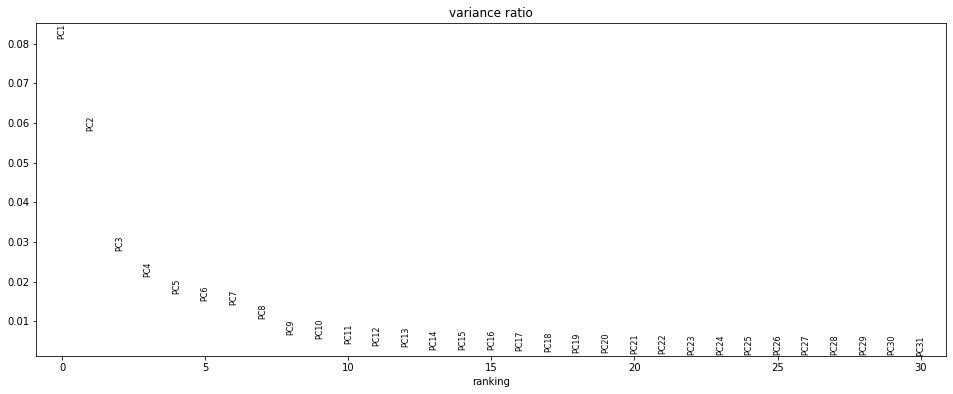

In [33]:
sc.plotting.pca_variance_ratio(adata)

You can plot any dimensionality reduction and colour cells by elements of `adata.obs` or by gene expression. Below we plot the three different samples composing the dataset, the total number of transcripts and the expression of SYCP1.

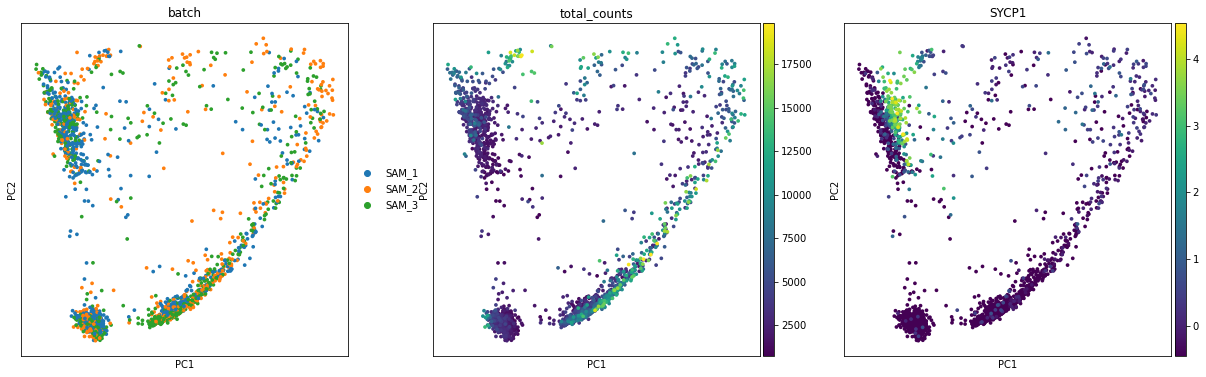

In [34]:
plt.rcParams['figure.figsize'] = (6,6)
sc.pl.pca(adata, color=['batch','total_counts','SYCP1'])

**tSNE and UMAP**

Scanpy allows to project the data with two methods, *tSNE* and *UMAP*. They are both based on interpreting the data as a graph whose vertices are the cells. To run both methods, we have to calculate the *k-nearest neighbours* to each cell (the k most similar cells to each cell). To do this we can use the command `sc.preprocessing.neighbors`. In our specific dataset, we have multiple biological replicates, and it is better to use a tool specific to such a situation, with the command `sc.external.pp.bbknn`. Note that we must choose the number of PC (Principal Components) of the PCA, since the algorithms are based on the PCA projection for efficiency purpose. 
tSNE requires the tuning of the perplexity (a parameter controlling the size of the neighbourhood of each point), while UMAP is more robust without tuning parameters.
Check these pages for more information on the two tools: [tSNE](https://distill.pub/2016/misread-tsne/) and [UMAP](https://umap-learn.readthedocs.io/en/latest/).

In [35]:
sc.external.pp.bbknn(adata, n_pcs=15, batch_key='batch')

In [36]:
sc.tools.tsne(adata, n_pcs=15, random_state=12345) #"resolution' left by default (30). Values between 5 and 50 are usually suggested for stability of the result.

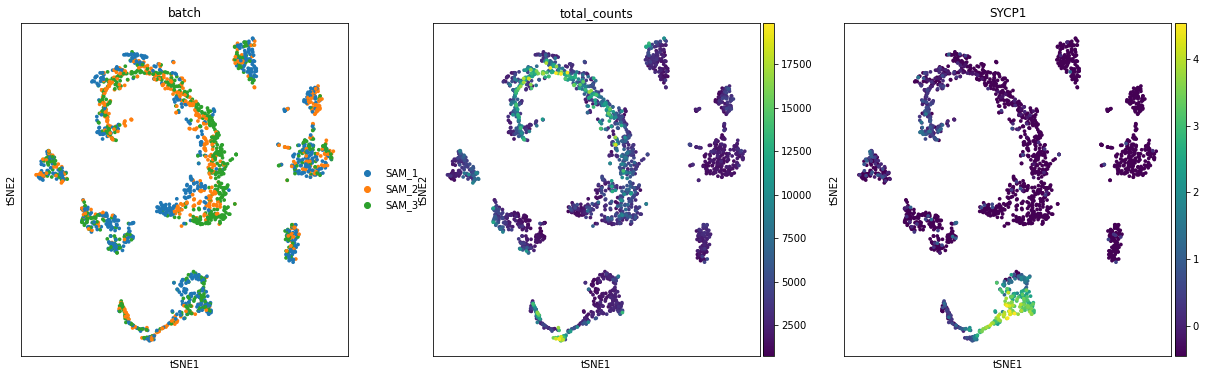

In [37]:
sc.plotting.tsne(adata, color=['batch','total_counts','SYCP1'])

The tSNE plot can change considerably if we change the perplexity parameter. A smaller perplexity will consider the structure of a smaller 'area' close to each cell, therefore losing the global structure of the biological process we are studying

In [38]:
sc.tools.tsne(adata, n_pcs=15, random_state=12345, perplexity=5)

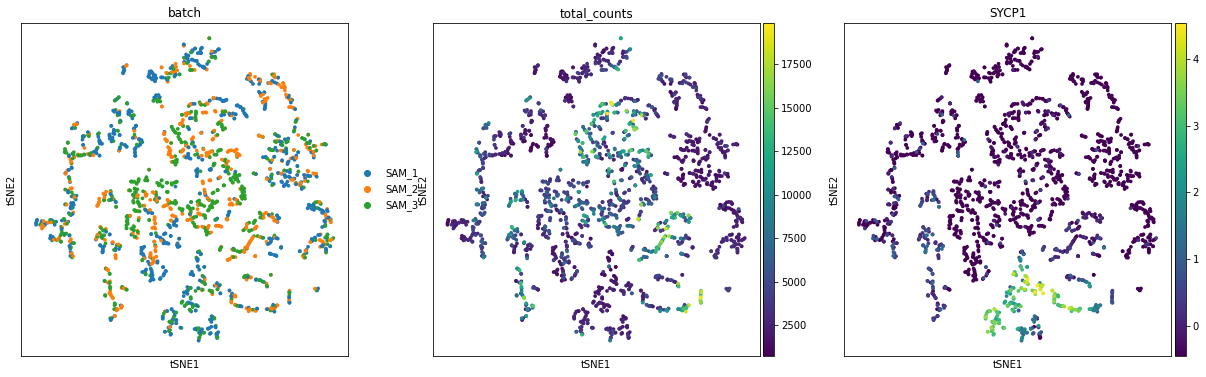

In [39]:
sc.plotting.tsne(adata, color=['batch','total_counts','SYCP1'])

A higher perplexity (50) shows the presence of a clearer structure of the biological process, similarly to what happens with the default perplexity.

In [40]:
sc.tools.tsne(adata, n_pcs=15, random_state=12345, perplexity=50)

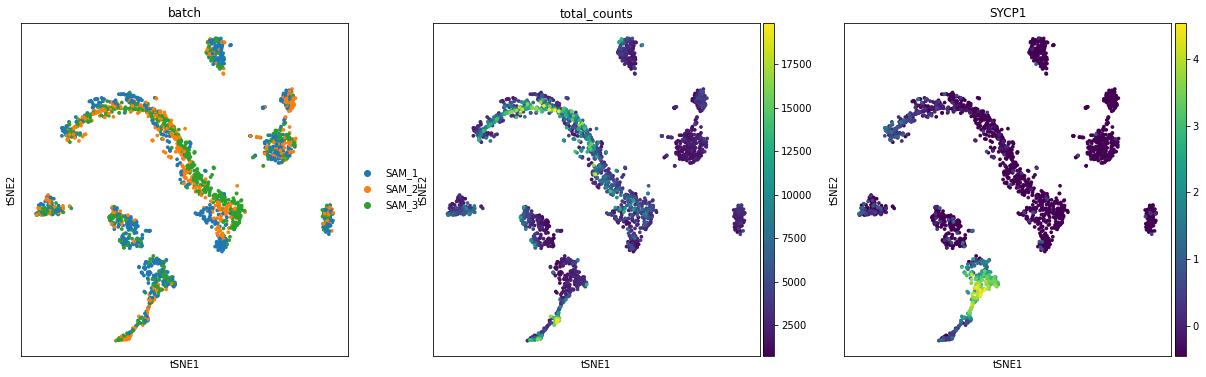

In [41]:
sc.plotting.tsne(adata, color=['batch','total_counts','SYCP1'])

We now apply UMAP, that usually works in a reliable way without setting any parameter. This is possible because UMAP is based on the mathematical understanding of how to select the optimal 'area' around each cell and to maintain specific properties of the geometric space where the data points are located

In [42]:
sc.tools.umap(adata, random_state=12345)

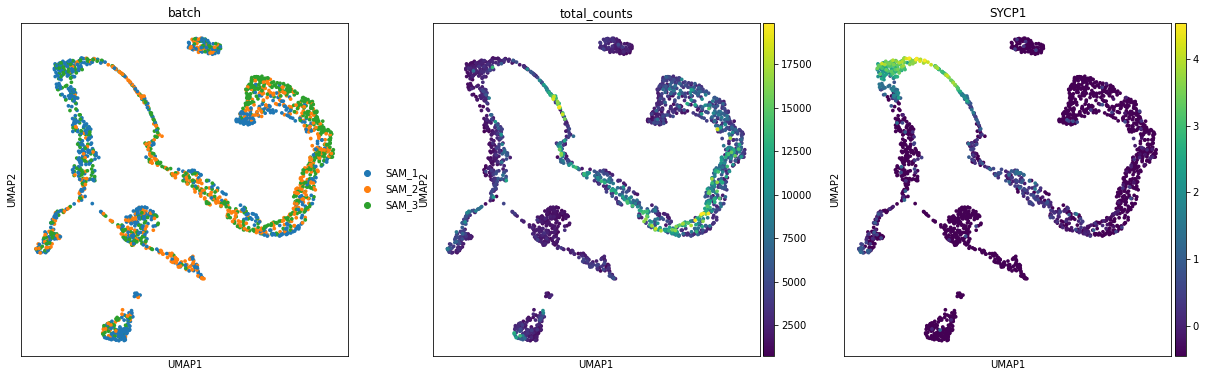

In [43]:
sc.plotting.umap(adata, color=['batch','total_counts','SYCP1'])

**SECOND BREAKOUTROOM SESSION STARTS HERE**

##Clustering

Various clustering techniques are possible to identify similar cells. Note that, when identifying a cluster, we can assign that a likely cell type by using for example known markers. However, be aware that clusters do not necessarily match perfectly cell types (especially if cells change in a continuous way, hard clusters are not the best solution). 
Scanpy contains the *leiden* approach, making clusters whose points are well connected and at the same time mostly disconnected from other clusters. Other approaches, e.g. *k-means*, can be performed on the data or on its PCA/tSNE/UMAP projection.

While *leiden* requires to specify a resolution parameters influencing the number of clusters, other algorithms such as *k-means* require directly the number of desired clusters.

In [44]:
#leiden clustering
sc.tools.leiden(adata, resolution=1, random_state=12345, key_added='leiden_R1')
sc.tools.leiden(adata, resolution=0.5, random_state=12345, key_added='leiden_R.5')
sc.tools.leiden(adata, resolution=0.25, random_state=12345, key_added='leiden_R.25')
sc.tools.leiden(adata, resolution=0.1, random_state=12345, key_added='leiden_R.1')

We can see that at resolution 1 we have many clusters, and their number decreases with decreasing resolution. A way to choose how many cluster to keep, is to look at how correlated they are in the correlation matrix. Two very correlated clusters might just be a matching cell type, and they could be merged into one cluster

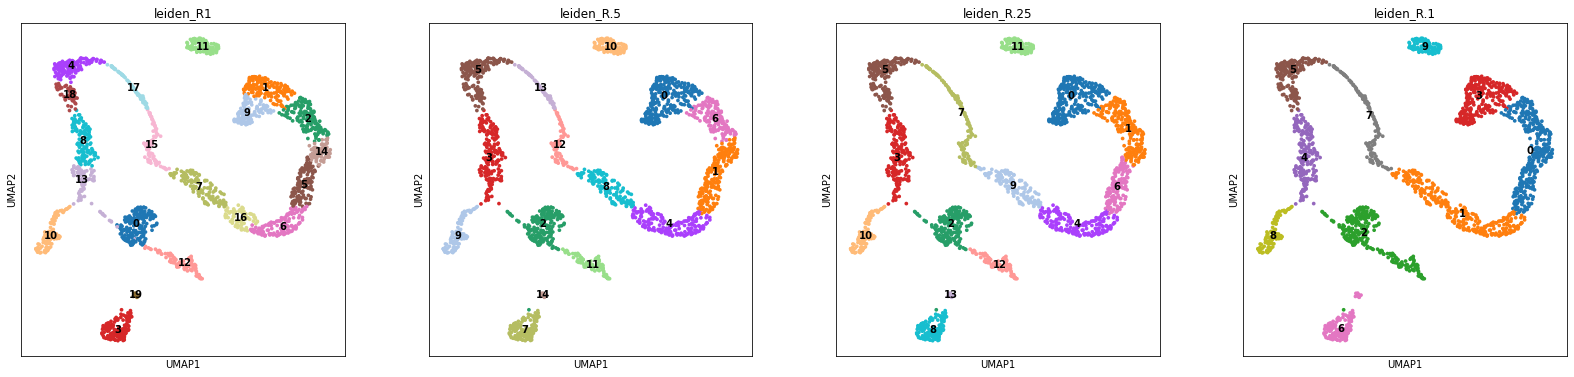

In [45]:
sc.plotting.umap(adata, color=['leiden_R1','leiden_R.5','leiden_R.25', 'leiden_R.1'], legend_loc='on data')

We plot correlation matrices starting from resolution 0.1. Note that at resolution 0.25, three clusters are very correlated (for example considering a threshold of 0.8), i.e. clusters 0, 1 and 6, that are also close to each other in the UMAP plot. Resolution 0.5 increases the correlation of clusters 0,1 and 6, probably reducing the number of cells assigned to them, and creates other clusters with increased correlation. At resolution 1 the number of clusters is strongly increased, as well as the between-clusters correlation. Taking into account that our data is very sparse, it is unlikely that one can recognise different cellular stages in such correlated clusters. The best choice is probably to consider either the clustering at resolution 0.1 or 0.25.

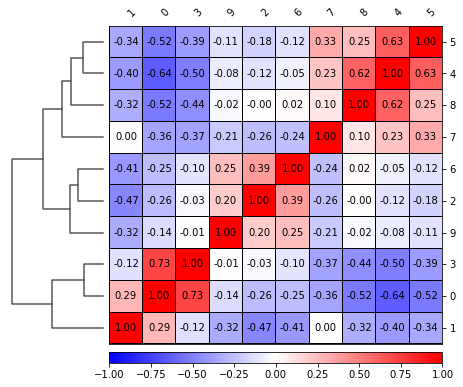

In [46]:
sc.pl.correlation_matrix(adata, 'leiden_R.1', show_correlation_numbers=True)

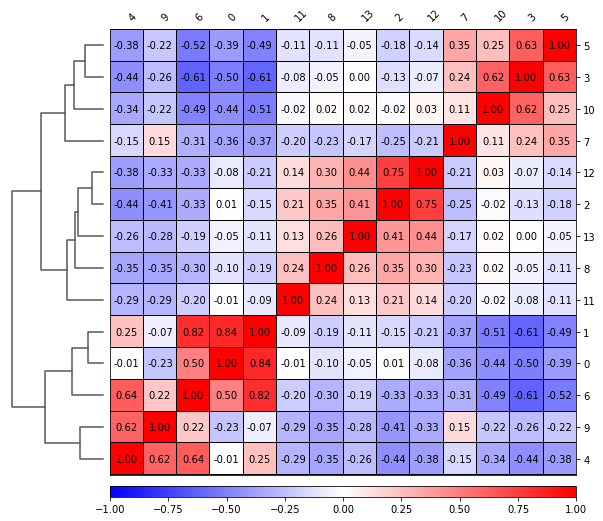

In [47]:
sc.pl.correlation_matrix(adata, 'leiden_R.25', show_correlation_numbers=True)

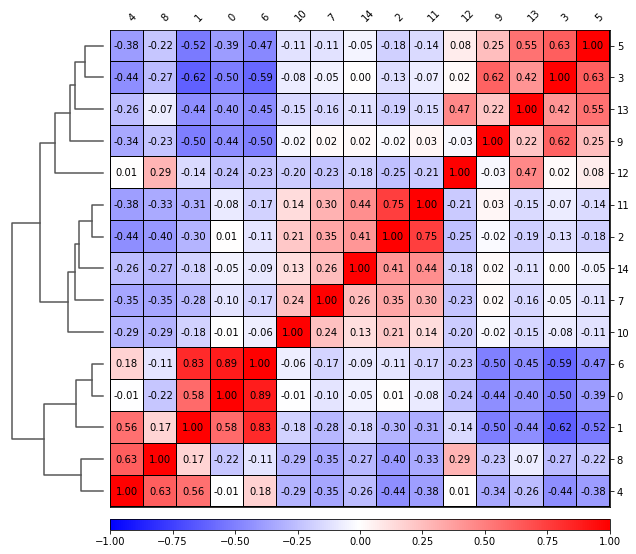

In [48]:
sc.pl.correlation_matrix(adata, 'leiden_R.5', show_correlation_numbers=True)

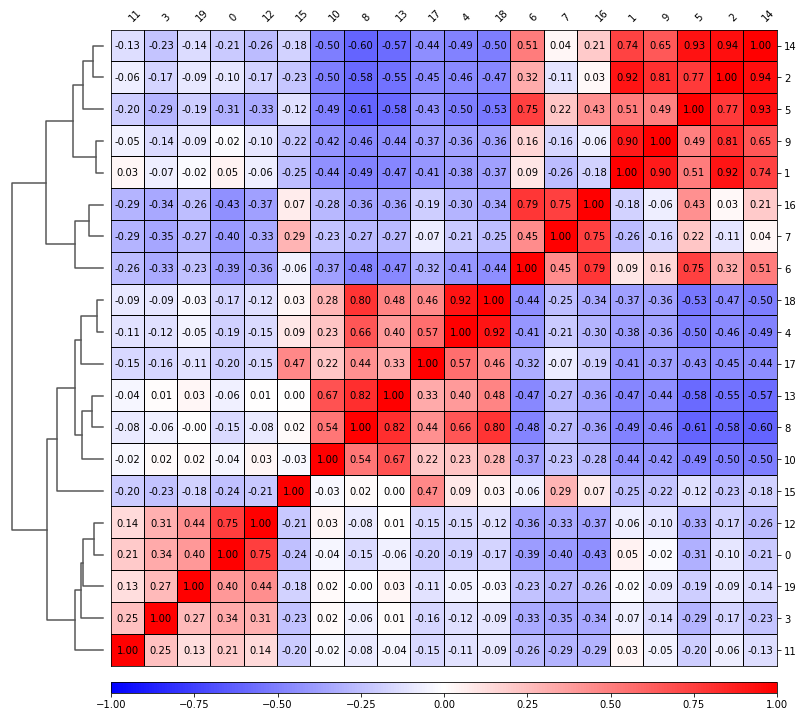

In [49]:
sc.pl.correlation_matrix(adata, 'leiden_R1', show_correlation_numbers=True)

In [50]:
#note: you can calculate and read the correlation matrix also in this way
sc.tl.dendrogram(adata, 'leiden_R.1')
corr=pd.DataFrame(adata.uns['dendrogram_leiden_R.1']['correlation_matrix'],
             index=adata.uns['dendrogram_leiden_R.1']['categories_idx_ordered'],
             columns=adata.uns['dendrogram_leiden_R.1']['categories_idx_ordered'])
corr

,1,0,3,9,2,6,7,8,4,5
1,1.000000,0.285601,-0.261171,0.732448,-0.637189,-0.522024,-0.252599,-0.357538,-0.522348,-0.140051
0,0.285601,1.000000,-0.469741,-0.118343,-0.395812,-0.342684,-0.405769,0.001437,-0.318445,-0.321892
3,-0.261171,-0.469741,1.000000,-0.025925,-0.115908,-0.177711,0.386830,-0.257748,-0.003429,0.199746
9,0.732448,-0.118343,-0.025925,1.000000,-0.500725,-0.385141,-0.104716,-0.366141,-0.440213,-0.006535
2,-0.637189,-0.395812,-0.115908,-0.500725,1.000000,0.628260,-0.048272,0.231584,0.616131,-0.077626
6,-0.522024,-0.342684,-0.177711,-0.385141,0.628260,1.000000,-0.115803,0.334469,0.250959,-0.110434
7,-0.252599,-0.405769,0.386830,-0.104716,-0.048272,-0.115803,1.000000,-0.244776,0.018078,0.250089
8,-0.357538,0.001437,-0.257748,-0.366141,0.231584,0.334469,-0.244776,1.000000,0.097590,-0.205488
4,-0.522348,-0.318445,-0.003429,-0.440213,0.616131,0.250959,0.018078,0.097590,1.000000,-0.023527
5,-0.140051,-0.321892,0.199746,-0.006535,-0.077626,-0.110434,0.250089,-0.205488,-0.023527,1.000000


Using the correlation as a measure for evaluating clustering is motivated by the fact that it captures the changes in gene expression between clusters. We can use other methods based on the euclidean distance to calculate a score for the clustering resolutions. One method could be the well-known [silhouette score](https://en.wikipedia.org/wiki/Silhouette_(clustering)#:~:text=The%20silhouette%20value%20is%20a,poorly%20matched%20to%20neighboring%20clusters.). This calculates a score for each cluster based on how close cells are to each other. However, our data is highly non linear, and the silhouette score is based on a distance that works better on linear datasets. To speed up calculations, we use the first 15 dimensions of the PCA projection as a proxy for the whole dataset.
Here we have the resolutions 0.25 and 0.5 classified almost equally as the best ones, followed tightly by resolution 0.1. Taking into account what we have seen in the correlation matrices, we confirm the choice of the clustering at resolution 0.25.

In [51]:
import sklearn.metrics as METRICS

score_R1 = METRICS.silhouette_score( adata.obsm['X_pca'][:,0:15], 
                                            np.asarray(adata.obs['leiden_R1']) )
score_R0_5 = METRICS.silhouette_score( adata.obsm['X_pca'][:,0:15], 
                                              np.asarray(adata.obs['leiden_R.5']) )
score_R0_25 = METRICS.silhouette_score( adata.obsm['X_pca'][:,0:15], 
                                               np.asarray(adata.obs['leiden_R.25']) )
score_R0_1 = METRICS.silhouette_score( adata.obsm['X_pca'][:,0:15], 
                                              np.asarray(adata.obs['leiden_R.1']) )
print('Silhouette score at resolution')
print('R=1\t   R=0.5\tR=0.25\t  R=0.1')
print(score_R1, score_R0_5, score_R0_25, score_R0_1)

Silhouette score at resolution
R=1	   R=0.5	R=0.25	  R=0.1
0.38661268 0.46159902 0.46106127 0.44881752


An alternative type of clustering is given by the kmeans. This can be based on many different distances (for example euclidean) to determine which cells are closest to each other and pertain to a cluster, but the python implementation of sklearn uses only the euclidean distance. Let's make as many clusters as for the resolution of choice with the leiden algorithm. Again, we speed up computations using the first 15 components of the PCA.

In [52]:
from sklearn.cluster import KMeans

N=14
kmeans_obj = KMeans(n_clusters=N, random_state=12345)
kmeans_clusters = kmeans_obj.fit_predict(adata.obsm['X_pca'][:,0:15])
adata.obs['kmeans_14'] = pd.Categorical(kmeans_clusters)

We can see that, compared to leiden, the kmeans put together clusters 0,1 and also 12,13, while splitting cluster 7 and 4.

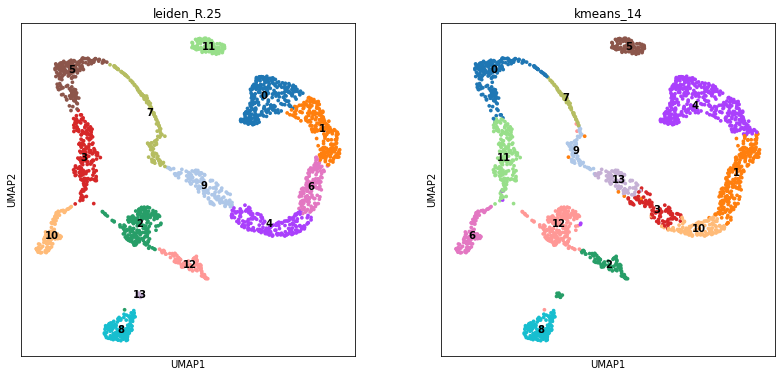

In [53]:
sc.plotting.umap(adata, color=['leiden_R.25','kmeans_14'], legend_loc='on data', ncols=3)

We can use again the correlation matrix to evaluate the clustering.

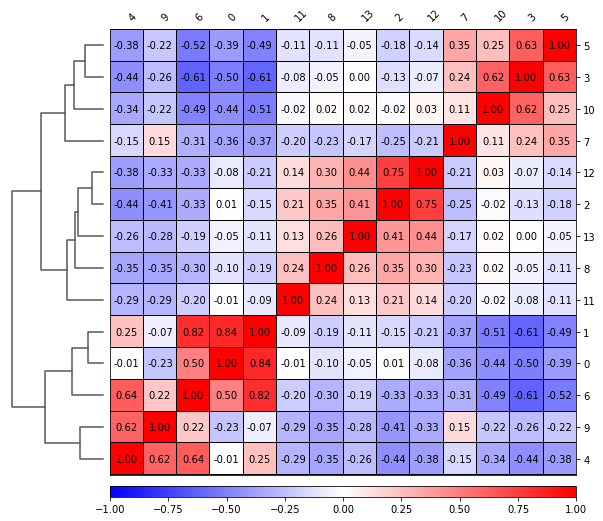

In [54]:
sc.pl.correlation_matrix(adata, 'leiden_R.25', show_correlation_numbers=True)

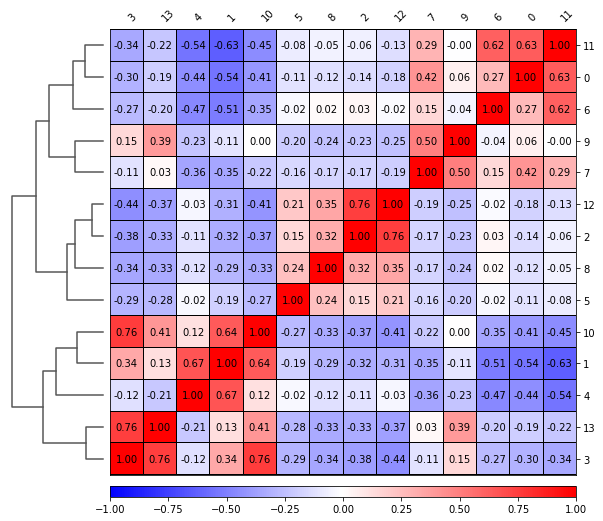

In [55]:
sc.pl.correlation_matrix(adata, 'kmeans_14', show_correlation_numbers=True)

The two clusterings have similar average correlation, however the median correlation of the leiden clustering is quite lower (~0.25 vs ~0.3), meaning that half of the correlation values of the kmeans clustering are above 0.3. We dedice to continue with the leiden clustering at resolution 0.25. In general, it is advisable to use the leiden clustering methods amongst the standard methods available.

In [56]:
corr_leiden = pd.DataFrame(adata.uns['dendrogram_leiden_R.25']['correlation_matrix'],
             index=adata.uns['dendrogram_leiden_R.25']['categories_idx_ordered'],
             columns=adata.uns['dendrogram_leiden_R.25']['categories_idx_ordered'])
corr_kmeans = pd.DataFrame(adata.uns['dendrogram_kmeans_14']['correlation_matrix'],
             index=adata.uns['dendrogram_kmeans_14']['categories_idx_ordered'],
             columns=adata.uns['dendrogram_kmeans_14']['categories_idx_ordered'])

In [57]:
np.mean( np.triu( corr_leiden,1 )[np.triu( corr_leiden,1 )>0]  ) #average leiden correlation

0.3289407582505293

In [58]:
np.median( np.triu( corr_leiden,1 )[np.triu( corr_leiden,1 )>0]  ) #median leiden correlation

0.2509587025833366

In [59]:
np.mean( np.triu( corr_kmeans,1 )[np.triu( corr_kmeans,1 )>0]  ) #average kmeans correlation

0.3368692453277803

In [60]:
np.median( np.triu( corr_kmeans,1 )[np.triu( corr_kmeans,1 )>0]  ) #median kmeans correlation

0.3062046825948308

Note: the kmeans will often be likely to have a higher score than the leiden algorithm, since both kmeans and silhouette score are based on the euclidean distance and misses the non linear structure of the data. Therefore comparing kmeans and leiden algorithms with the silhouette score would be an unfair comparison.

In [61]:
score_kmeans = sklearn.metrics.silhouette_score( adata.obsm['X_pca'][:,0:15], 
                                            np.asarray(adata.obs['kmeans_14']) )

print('Silhouette score for kmeans with 14 clusters', score_kmeans)

Silhouette score for kmeans with 14 clusters 0.52823347


##Cluster assignment
Defining the most likely cell type present in a cluster is a very complicated task, especially when the cells change from one type to another in a very continuous fashion, making the "hard clustering" not a completely realistic model. Some methods allow "implicitely" to assign cell types: this is for example possible by using the tool SDA (external tool not implemented in python), that identifies modules of relevant marker genes and assigns them a score for each cell in the dataset. In this way, knowing relevant markers for cell types, it is possible to use thos scores as a "smooth" cell type assignment. Another possibility is to use supervised classifiers trained on curated single cell atlases.
However, for many applications, a hard clustering associated with a careful markers analysis is a well-accepted technique in the scientific community, and is used in basically the totality of the state-of-the-art publications.

Here, using previous biological knowledge, we define a dictionary. A dictionary is a python object in which you can allocate different things (matrices, vectors, ...), each of which has an assigned name. Here we save lists of marker genes, where each list is identified by the name of the corresponding cell type. To remember the different stages of spermatogenesis, a [scheme](https://www.digital-world-medical-school.net/01.%20Medical%20School/1.%201st/05.%20%20Cells/02.%20Cell%20%20Division/Meiosis/Spermatogenesis.html) is attached below
![](https://www.digital-world-medical-school.net/01.%20Medical%20School/1.%201st/05.%20%20Cells/02.%20Cell%20%20Division/Meiosis/Spermatogenesis_Clonal.png)

In [ ]:
markers = dict()
markers['SpermatogoniaA'] = ['ID4']
markers['Mitosis'] = ['MKI67','DMRT1']
markers['Spermatogonia B'] = ['STRA8'] 
markers['Meiosis'] = ['MEIOB','SYCP1']
markers['Spermatocytes'] = ['PIWIL1']
markers['Round.Spt'] = ['SPATA9','SPAM1']
markers['Elong.Spt'] = ['PRM1']
### SOMATIC CELLS
markers['Sertoli'] = ['VIM','CTSL']
markers['Macroph'] = ['CD163','TYROBP']
markers['Leydig'] = ['CFD']
markers['Endothelial'] = ['CD34']
markers['Myoid'] = ['ACTA2']

A first strategy to form an idea of which cell types are present in the data, is to plot the markers expression on the UMAP plot, and in some type of heatmap as follows

In [ ]:
sc.plotting.umap(adata, color=['leiden_R.25'], legend_loc='on data', ncols=3)

In [ ]:
sc.plotting.umap(adata, color=markers['SpermatogoniaA'], legend_loc='on data', ncols=3)

In [ ]:
sc.plotting.umap(adata, color=markers['Mitosis'], legend_loc='on data', ncols=3)

In [ ]:
sc.plotting.umap(adata, color=markers['Spermatogonia B'], legend_loc='on data', ncols=3)

In [ ]:
sc.plotting.umap(adata, color=markers['Meiosis'], legend_loc='on data', ncols=3)

In [ ]:
sc.plotting.umap(adata, color=markers['Spermatocytes'], legend_loc='on data', ncols=3)

In [ ]:
sc.plotting.umap(adata, color=markers['Round.Spt'], legend_loc='on data', ncols=3)

In [ ]:
sc.plotting.umap(adata, color=markers['Elong.Spt'], legend_loc='on data', ncols=3)

In [ ]:
sc.plotting.umap(adata, color=markers['Myoid'], legend_loc='on data', ncols=3)

In [ ]:
sc.plotting.umap(adata, color=markers['Macroph'], legend_loc='on data', ncols=3)

In [ ]:
sc.plotting.umap(adata, color=markers['Leydig'], legend_loc='on data', ncols=3)

In [ ]:
sc.plotting.umap(adata, color=markers['Endothelial'], legend_loc='on data', ncols=3)

Identifying sertoli cells it is usually a difficult task. Often, sertoli cells are not captured in microdroplet methods, since they have a rather large size compared to other cells and to the droplet themselves. Moreover, Sertoli markers are often expressed in the other somatic cells as well, making an eventual identification rather hard. Proceeding by exclusion from the markers seen above, it is maybe possible that the tiny cluster number 13 consists of Sertoli cells.

In [ ]:
sc.plotting.umap(adata, color=markers['Sertoli'], legend_loc='on data', ncols=3)

To better support the cluster identification from a statistical point of view, we can calculate the differential gene expression. A standard way to do it, is to test if each gene has mean expression higher in a cluster than in all the others. Scanpy does that by using a t-test or the wilcoxon test. While the t-test is less powerful, the wilcoxon test is not best behaved with very sparse data. Let's simply apply the default t-test to the dataset.
Note that, for the standard t-test in scanpy, you need to use logarithmized data. Fortunately, this is saved in one of the layers and can be assigned to `adata.X`

In [ ]:
#Perform the test
adata.X = adata.layers['log_counts'].copy()
sc.tl.rank_genes_groups(adata, groupby='leiden_R.25')

We can plot the most differentially expressed genes of each cluster after testing. Genes are ordered by score, a measure related to their mean expression in the cluster compared to the other clusters. For some clusters it is immediately clear the identity. Clusters 0 and 1 express PRM2 and TNP1, known markers of elongated spermatids. Cluster 2 shows DCN and CFD, marker for Leydig cells. Cluster 3 shows DMRT1, a marker for cells undergoing mitosis up to spermatogonia type B, and so on. 

In [ ]:
#plot the test results
sc.pl.rank_genes_groups(adata, groupby='leiden_R.25', fontsize=12)

Dotplots can again give a general overview of the gene expression, similarly to heatmaps. On top are defined the gene categories of our dictionary, on the bottom axis the single gene names. On the left are located the cluster names.

In [ ]:
sc.pl.dotplot(adata, groupby='leiden_R.25', var_names=markers, smallest_dot=.35, layer='gauss_counts')

In [ ]:
sc.pl.heatmap(adata, groupby='leiden_R.25', var_names=markers, layer='gauss_counts', vmin=0, vmax=3)

It is not really possible to identify cluster 13, so we decide to remove it from the data. It contains after all very few cells, and the scores of differentially expressed genes are quite low.

In [ ]:
adata = adata[ adata.obs['leiden_R.25']!='13' ].copy()

We now rename the categories we found in our observations about clusters. Some cluster will be named the same and will be merged. In some cases, it is hard to have a specific cluster (for example Mitosis and Spermatogonia B are basically overlapping, so we call that cluster just SpermatogoniaB)

In [ ]:
adata.obs['leiden_R.25'].cat.categories #print the cluster numbers

In [ ]:
adata.obs['clustering'] = adata.obs['leiden_R.25'].copy() #copy cluster vector with numbers
adata.rename_categories('clustering', ['ElongSpt_1','ElongSpt_2','Leydig','SpermatogoniaB',
                                           'RoundSpt_1', 'Meiosis', 'ElongSpt_3', 'Spermatocites', 
                                           'Endothelial', 'RoundSpt_2', 'SpermatogoniaA', 
                                            'Macroph', 'Myoid'])

We merge the clusters with same names. This cannot be done with a *categorical* object, where categories cannot have the same name. We convert the cluster names into a simple *array* to do this, and then reconvert it to a categorical object. Now we have successfully assigned cell type names.

In [ ]:
clustering = np.array( adata.obs['clustering'] )
clustering = [np.str.split(i, '_')[0] for i in clustering] #split by character _ and take the first part (the name of the cell type)
adata.obs['clustering'] = pd.Categorical(clustering)

In [ ]:
plt.rcParams['figure.figsize'] = (8,8)
sc.pl.umap( adata, color=['clustering'], 
           legend_loc='on data', 
           legend_fontsize=16,
           frameon=False )

**THIRD BREAKOUTROOM SESSION STARTS HERE**

## Advanced analysis: Pseudotimes and cell fates

It is possible to calculate the distance of each cell from the origin of a biological process. This distance - called pseudotime - is used to order the cells in the biological process. Moreover, it is possible to simulate differentiation paths between cells to extrapolate the cells most likely to be representative of different cellular fates. To perform this analysis, we use the package *palantir*. Other similar packages to perform this kind of analysis are *Monocle3* (R package) and *destiny*.
Such analysis is usually applied to a continuous differentiation process, therefore we subset the data to include only germ cells.

In [ ]:
#subset the data excluding somatic cells
germData = adata[ [ i not in ['Endothelial', 'Myoid', 'Macroph', 'Leydig'] for i in adata.obs['clustering'] ] ].copy()

the data contains now only 1605 cells, i.e. the germ cells of interest

In [ ]:
germData

In [ ]:
sc.pl.umap( germData, color=['clustering'], 
           legend_loc='on data', 
           legend_fontsize=16,
           frameon=False )

We import *palantir* and define as data matrix for the analysis the logarithmized count matrix. We assign as *index* (row names) the cell barcodes, and as *columns* (columns names) the gene symbols.

In [ ]:
import palantir

palantir_data = pd.DataFrame(germData.layers['log_counts'].todense(),
                             index=germData.obs_names,
                             columns=germData.var_names)

*palantir* uses by default the first 300 PCA components. Since we calculated only few of them in our dataset, we let the program calculate the PCA again

In [ ]:
pca_projections, _ = palantir.utils.run_pca(palantir_data)

In [ ]:
pca_projections.head()

Calculate the diffusion maps, a type of projection needed to calculate the cell ordering, and the multiscale space, i.e. a representation of the data that allows for multiple cell fates.

In [ ]:
dm_res = palantir.utils.run_diffusion_maps(pca_projections, n_components=5)

In [ ]:
ms_data = palantir.utils.determine_multiscale_space(dm_res)

Since we already calculated the UMAP projection, we extract that from the *germData* object instead of calculating the *tSNE* coordinates with *palantir*. We can see that the plot matches our previous UMAP plots.

In [ ]:
projection = pd.DataFrame(germData.obsm['X_umap'][:,0:2],
                          index=germData.obs_names,
                          columns=['x','y'])

In [ ]:
fig, ax = palantir.plot.plot_tsne(projection)

Now, we select a random cell from the origin of spermatogenesis (cluster *SpermatogoniaA*). Then we make *palantir* calculate the potential cell fates.

In [ ]:
start_cell = str(germData[germData.obs['clustering'] == 'SpermatogoniaA'].obs_names[0])
pr_res = palantir.core.run_palantir(ms_data, start_cell, num_waypoints=1000)

It is possible to plot the cell ordering (pseudotime) and the amount of contribution to the cellular fate (differentiation potential). The lowest part of the plot shows how much each cell is likely to be part of one of multiple cell fates (in our case two).
We can observe two things:
- The spermatogenic and meiotic stages show some differentiation potential, while spermatocytes do not seem contributing to any cell fate. This is probably due to a relevant inactivation of genes, called meiotic sex chromosome inactivation (MSCI)
- Late round spermatids and early elongated spermatids show very high differentiation potential, while late elongated spermatids aren't giving relevant contribution. This happens probably because late elongated spermatids cells are at a very advanced development stage and we do not observe relevant changes in transciption between cell, while the earlier stage are strongly expressing relevant groups of genes while on their way to become spermatozoa.

In [ ]:
palantir.plot.plot_palantir_results(pr_res, projection)

we can also visualize which cells best represent the cell fates. It is interesting to observe how those two points match almost exactly the end of the spermatocytes stage and the very end of the elongated spermatids cluster.

In [ ]:
end_states = np.asarray(pr_res.branch_probs.columns)

In [ ]:
palantir.plot.highlight_cells_on_tsne(projection, end_states)

We can save some of the results into our object *germData*

In [ ]:
fates = pr_res.branch_probs
fates.columns = ['MSCI','Spermatids']

In [ ]:
fates.head()

In [ ]:
germData.obs['MSCI_fate'] = fates['MSCI']
germData.obs['SPERMATIDS_fate'] = fates['Spermatids']
germData.obs['palantir_pseudotimes'] = pr_res.pseudotime

In [ ]:
sc.pl.umap( germData, color=['clustering','MSCI_fate','SPERMATIDS_fate','palantir_pseudotimes'], 
           legend_loc='on data', 
           legend_fontsize=16,
           frameon=False )

##Advanced analysis: Gene Enrichment Analysis

We perform a simple test for differential expression for cells in the MSCI cell fate vs the other cells and viceversa. We can see which genes are most relevant in such a process. The MORF4L1 is connected to the regulation and suppression of apoptosis. This could imply that the cell fate is of apoptotic type for some of the cells after the meiotic stage. One can apply gene enrichment analysis to find out specific pathways, tissues, GO terms and others that are of relevance. We use [gseapy](https://gseapy.readthedocs.io/en/latest/index.html), a python package to explore Go terms, pathways and many other interesting databases for gene set enrichment.

In [ ]:
#define category where MSCI cells are those in the MSCI fate with probability>0.9
germData.obs['MSCI_cells'] = pd.Categorical( ['MSCI' if score>.9 else 'OTHER' for score in germData.obs['MSCI_fate']] )

In [ ]:
germData.X = germData.layers['log_counts'].copy()
sc.tools.rank_genes_groups(germData, groupby='MSCI_cells', key_added='DE_test_MSCI', n_genes=300)

In [ ]:
sc.pl.rank_genes_groups(germData, key='DE_test_MSCI')

In [ ]:
germData.uns['DE_test_MSCI']['names']['MSCI']

In [ ]:
gene_list = germData.uns['DE_test_MSCI']['names']['MSCI']

In [ ]:
#choose the human database and show which info can be retrieved
names = gp.get_library_name('Human') #Other databases: ‘Mouse’, ‘Yeast’, ‘Fly’, ‘Fish’, ‘Worm’  
names

In [ ]:
enr = gp.enrichr(gene_list=np.ndarray.tolist(gene_list),
                 gene_sets=['WikiPathways_2019_Human'],
                 organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
                 description='test_name',
                 outdir='test/enrichr_kegg',
                 # no_plot=True,
                 cutoff=0.5 # test dataset, use lower value from range(0,1)
                )

you can see results as a giant table

In [ ]:
enr.results

you can also plot them. It does not seem that the genes for the MSCI fate show a pathway of some relevance. One does probably need to dig deeper into the data.

In [ ]:
from gseapy.plot import barplot, dotplot
barplot(enr.results, cutoff=.25)

Here we can see that the relevant genes after the potential MSCI fate are very much related to sperm

In [ ]:
gene_list = germData.uns['DE_test_MSCI']['names']['OTHER']

In [ ]:
enr = gp.enrichr(gene_list=np.ndarray.tolist(gene_list),
                 gene_sets=['GO_Biological_Process_2018'],
                 organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
                 description='test_name',
                 outdir='test/enrichr_kegg',
                 # no_plot=True,
                 cutoff=0.5 # test dataset, use lower value from range(0,1)
                )

Amongst the top GO biological processes we have spermatid development and sperm motility, but their pvalues are not significant enough

In [ ]:
enr.results

you can also plot them. Here we can see that the relevant genes we think related to MSCI do not really show pathways of relevance.

In [ ]:
from gseapy.plot import barplot, dotplot
barplot(enr.results, cutoff=0.25)